## **Exploratory Data Analysis**

Before introducing any model, we conducted an exploratory data analysis to clean and better understand our dataset.
 
The dataset used in this project was obtained from Kaggle and is available at the following link:     
[Multilingual Customer Support Tickets](https://www.kaggle.com/datasets/tobiasbueck/multilingual-customer-support-tickets?select=dataset-tickets-multi-lang3-4k.csv)   
 
It contains a collection of real-world customer support tickets written in english or german, along with metadata such as ticket subject, body, language, assigned queue, priority, and various tags.    
 
We chose this dataset because it offers rich information (dataset size: 20k records) that allows us to classify the appropriate queue for each support ticket based on the given details. By analyzing the info given, we aim to predict which team or department (queue) should handle the ticket.     
 
This classification task can help to automatize the assignment process in customer support systems, ensuring that each ticket is directed to the right team for a timely and effective response.

### Import Libraries

In [127]:
import sys
sys.path.append('..')
import os
import csv

In [128]:
# Data science libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from collections import Counter
from sklearn.model_selection import train_test_split

# Custom libraries
from src.data_exploration_utils import *

### Dataset

In [129]:
# Read the CSV file into a DataFrame
df_tickets_initial = pd.read_csv('../data/dataset-tickets-multi-lang-4-20k.csv')
df_tickets_initial.head()

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN


In [130]:
df_tickets_initial.shape

(20000, 15)

We can appreciate that the dataset contains the next variables:
- `subject`: Subject of the customer's email.
- `body`: Body of the customer's email.
- `answer`: The response provided by the helpdesk agent.
- `type`: The type of ticket as picked by the agent (Incident, Request, Problem, Change).
- `queue`: Specifies the department to which the email ticket is routed (General Inquiry, Customer Service, Technical Support, IT Support, Product Support, Billing and Payments, Service Outages and Maintenance, Human Resources, Returns and Exchanges, Sales and Pre-Sales). 
- `priority`: Indicates the urgency and importance of the issue (low, medium, high).
- `language`: Indicates the language in which the email is written (de, en).
- `tag`: Tags/categories assigned to the ticket to further classify and identify common issues or topics, split into ten columns in the dataset (examples: "Product Support," "Technical Support," "Sales Inquiry").

##### Selection of variables

To predict the appropriate support ticket `queue`, we kept only the most relevant information. We retained the `subject` and `body` of the customer message and the `language` field, which is essential for distinguishing the language during model training.    

We excluded the `answer` field because it is provided after the queue is assigned, as well as the `type`, `priority`, and `tag_1` to `tag_8` fields due to their inconsistency or unreliability at ticket submission.     

In summary, we use only the customer's message (`subject` and `body`) and `language` to ensure a simple, fair, and effective model.

In [131]:
df_tickets_filtered = df_tickets_initial[['subject', 'body', 'language', 'queue']].copy()
df_tickets_filtered.head()

,subject,body,language,queue
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,de,General Inquiry
1,Customer Support Inquiry,Seeking information on digital strategies that...,en,Customer Service
2,Data Analytics for Investment,I am contacting you to request information on ...,en,Customer Service
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,de,Customer Service
4,Security,"Dear Customer Support, I am reaching out to in...",en,Customer Service


##### Check for duplicates

In [132]:
duplicate_count = df_tickets_filtered.duplicated().sum()
print(f"Number of duplicate records: {duplicate_count}")

Number of duplicate records: 0


##### Check datatypes and missing values

In [133]:
df_tickets_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   18539 non-null  object
 1   body      19998 non-null  object
 2   language  20000 non-null  object
 3   queue     20000 non-null  object
dtypes: object(4)
memory usage: 625.1+ KB


We observed 18,539 missing values for subject and 19,998 for body.      

Since having data in either field is useful, we will concatenate `subject` and `body` into a single variable called `text`, and only remove records where both fields are missing.

In [134]:
nan_in_both = df_tickets_filtered[ df_tickets_filtered['body'].isna() & df_tickets_filtered['subject'].isna() ].shape[0]
print(f"Number of records with NaN in both 'body' and 'subject': {nan_in_both}")

Number of records with NaN in both 'body' and 'subject': 0


In [135]:
df_tickets = df_tickets_filtered.copy()
df_tickets['text'] = df_tickets['subject'].fillna('') + " " + df_tickets['body'].fillna('')
df_tickets = df_tickets.drop(columns=['subject', 'body'])
df_tickets.head()

,language,queue,text
0,de,General Inquiry,Unvorhergesehener Absturz der Datenanalyse-Pla...
1,en,Customer Service,Customer Support Inquiry Seeking information o...
2,en,Customer Service,Data Analytics for Investment I am contacting ...
3,de,Customer Service,Krankenhaus-Dienstleistung-Problem Ein Medien-...
4,en,Customer Service,"Security Dear Customer Support, I am reaching ..."


In [136]:
df_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  20000 non-null  object
 1   queue     20000 non-null  object
 2   text      20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


All variables are of type object, which is appropriate since they all contain strings.    
 
Additionally, no missing values are present.

##### Differentiate by language

We noticed that the dataset contains records in two different languages: German and English. For tasks like text analysis and class balancing, it is important to work with data in a single language, as mixing both can introduce bias. For example, the same word might appear in different forms across languages (e.g., "error" in English and "Fehler" in German), and instead of being counted together in the frequency analysis, they would be treated as separate terms. This would distort the frequency distribution, especially if one language is overrepresented (as in this case applies to English).

We considered two options to address this:

**1. Translate the entire dataset into a single language (e.g., English)** – While this approach could introduce inaccuracies due to literal translations, idiomatic expressions, or domain-specific terminology, it seemed the simplest option given the biased and inconsistent nature of our dataset.

**2. Separate the data by language** – By leveraging the language column, we could have split the dataset and analyzed each language independently. This would enable more accurate text analysis and help with class balancing within each language group, minimizing potential bias from linguistic differences. However, we found that several entries were incorrectly labeled, so we implemented the detect_language function to identify and correct these errors. Even with this solution, some records still mixed both English and German, causing the language column to be unreliable in certain cases.

Therefore, we decided to correct the language labels for entries that consistently followed a single language, allowing us to analyze both classes, and subsequently translate all records into English to ensure consistency.

In [137]:
df_tickets['corrected_language'] = df_tickets['text'].apply(detect_language)

In [138]:
df_tickets[['text','language','corrected_language']].head()

,text,language,corrected_language
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,de,de
1,Customer Support Inquiry Seeking information o...,en,en
2,Data Analytics for Investment I am contacting ...,en,en
3,Krankenhaus-Dienstleistung-Problem Ein Medien-...,de,de
4,"Security Dear Customer Support, I am reaching ...",en,en


In [139]:
df_errors = df_tickets[df_tickets['language'] != df_tickets['corrected_language']]
print(df_errors)

      language                            queue  \
8           de                  Product Support   
9           de                  Product Support   
29          de                  Product Support   
37          de  Service Outages and Maintenance   
45          de             Billing and Payments   
...        ...                              ...   
19892       de             Billing and Payments   
19953       de                Technical Support   
19957       de                  General Inquiry   
19958       de                Technical Support   
19983       de                       IT Support   

                                                    text corrected_language  
8      Assistance Request Dear Customer Support, I am...                 en  
9      Support Request The latest data analysis repor...                 en  
29     Issue Regarding Encryption Dear Customer Suppo...                 en  
37     Problems with SaaS-Tools Integration System do...                 en

Now, we'll analyze the difference in the amount of data between English and German

In [140]:
en_count = df_tickets[df_tickets['corrected_language'] == 'en'].shape[0]
de_count = df_tickets[df_tickets['corrected_language'] == 'de'].shape[0]

total = en_count + de_count

en_pct = (en_count / total) * 100 if total > 0 else 0
de_pct = (de_count / total) * 100 if total > 0 else 0

print(f"English: {en_count} records ({en_pct:.2f}%)")
print(f"German: {de_count} records ({de_pct:.2f}%)")


English: 13890 records (69.52%)
German: 6089 records (30.48%)


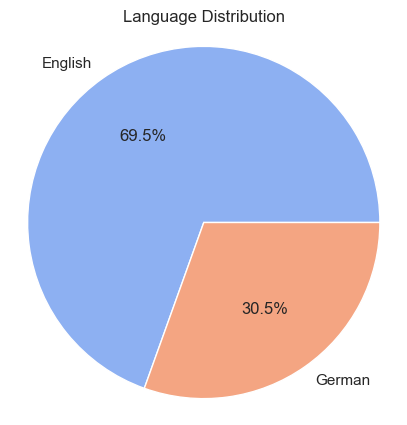

In [141]:
labels = ['English', 'German']
counts = [en_count, de_count]

plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors = ['#8DB0F2', '#F4A582'])
plt.title('Language Distribution')
plt.axis('equal')
plt.show()


**Translate to English**

With the following function, we translate the entire DataFrame into English to simplify both the analysis and the training of the models.

In [ ]:
df_tickets = translate_all_to_english(df_tickets)

In [ ]:
# Save the new translated csv
df_tickets.to_csv(
    path_or_buf=os.path.join("../data", "dataset-tickets-english.csv"),
    sep=";", 
    quoting=csv.QUOTE_ALL, 
    index=False
)

print("Translated DataFrame has been saved as 'dataset-tickets-english.csv'.")


##### Analyze class imbalance

In [142]:
# Read the CSV file into a DataFrame
df_english_initial = pd.read_csv('../data/dataset-tickets-english.csv')
df_english_initial.head()

,language,queue,text,corrected_language,text_en
0,de,General Inquiry,Unvorhergesehener Absturz der Datenanalyse-Pla...,unknown,Unexpected crash of the data analysis platform...
1,en,Customer Service,Customer Support Inquiry Seeking information o...,unknown,Customer Support Inquiry Seeking information o...
2,en,Customer Service,Data Analytics for Investment I am contacting ...,unknown,Data Analytics for Investment I am contacting ...
3,de,Customer Service,Krankenhaus-Dienstleistung-Problem Ein Medien-...,unknown,Hospital service problem A media data blocking...
4,en,Customer Service,"Security Dear Customer Support, I am reaching ...",unknown,"Security Dear Customer Support, I am reaching ..."


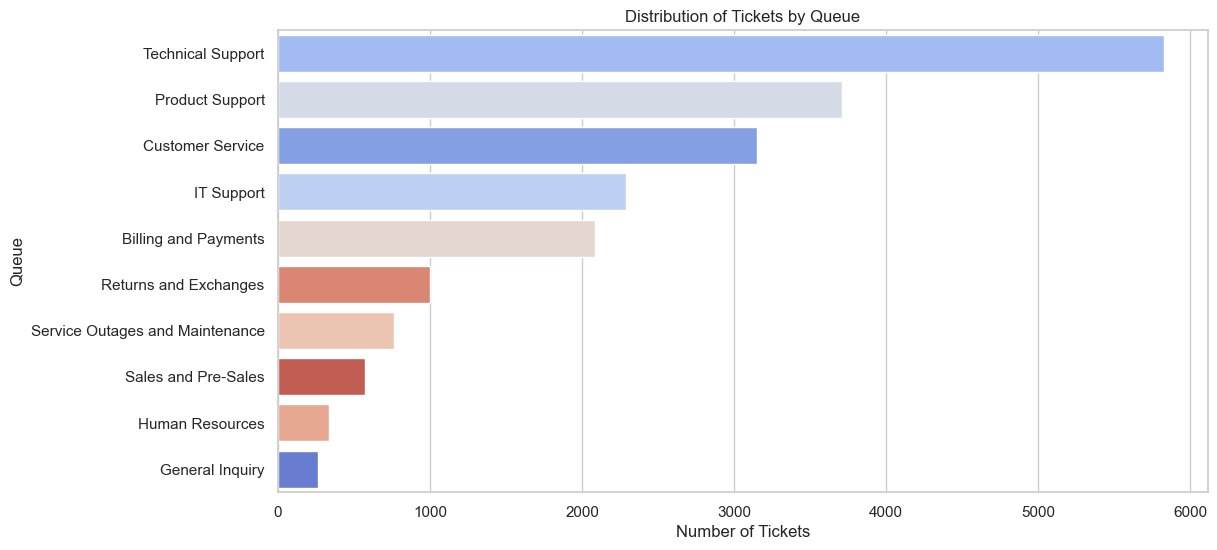

In [143]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.countplot(y=df_english_initial['queue'], order=df_english_initial['queue'].value_counts().index, palette="coolwarm", hue=df_english_initial['queue'])
plt.title("Distribution of Tickets by Queue")
plt.xlabel("Number of Tickets")
plt.ylabel("Queue")
plt.show()

In [144]:
check_class_imbalance(df_english_initial, 'queue')

,Counts,Percentage
queue,,
Technical Support,5824,29.12
Product Support,3708,18.54
Customer Service,3152,15.76
IT Support,2292,11.46
Billing and Payments,2086,10.43
Returns and Exchanges,1001,5.00
Service Outages and Maintenance,764,3.82
Sales and Pre-Sales,572,2.86
Human Resources,338,1.69


As we can see, there is a clear class imbalance in the dataset. Discarding records from the majority class would lead to the loss of valuable information, and augmenting the minority class is not ideal. Therefore, we have decided to adjust the classes by combining them to create a more balanced dataset. The categories will be combined as follows:
- **Class 1 - Technical/IT Support (40.6%)**: includes Technical Support, IT Support
- **Class 2 - Customer & Product Support (34.3%)**: includes Customer Service, Product Support
- **Class 3 - Financial/Other (25.1%)**: includes Billing and Payments, Returns and Exchanges, Service Outages and Maintenance, Sales and Pre-Sales, Human Resources, General Inquiry

In [145]:
category_mapping = {
    'Technical Support': 'Technical/IT Support',
    'IT Support': 'Technical/IT Support',
    'Customer Service': 'Customer & Product Support',
    'Product Support': 'Customer & Product Support',
    'Billing and Payments': 'Financial/Other',
    'Returns and Exchanges': 'Financial/Other',
    'Service Outages and Maintenance': 'Financial/Other',
    'Sales and Pre-Sales': 'Financial/Other',
    'Human Resources': 'Financial/Other',
    'General Inquiry': 'Financial/Other'
}

In [146]:
# Apply the mapping to the 'queue' column
df_english_initial['grouped_queue'] = df_english_initial['queue'].map(category_mapping)

In [147]:
df_english_initial[['queue', 'grouped_queue']].head()

,queue,grouped_queue
0,General Inquiry,Financial/Other
1,Customer Service,Customer & Product Support
2,Customer Service,Customer & Product Support
3,Customer Service,Customer & Product Support
4,Customer Service,Customer & Product Support


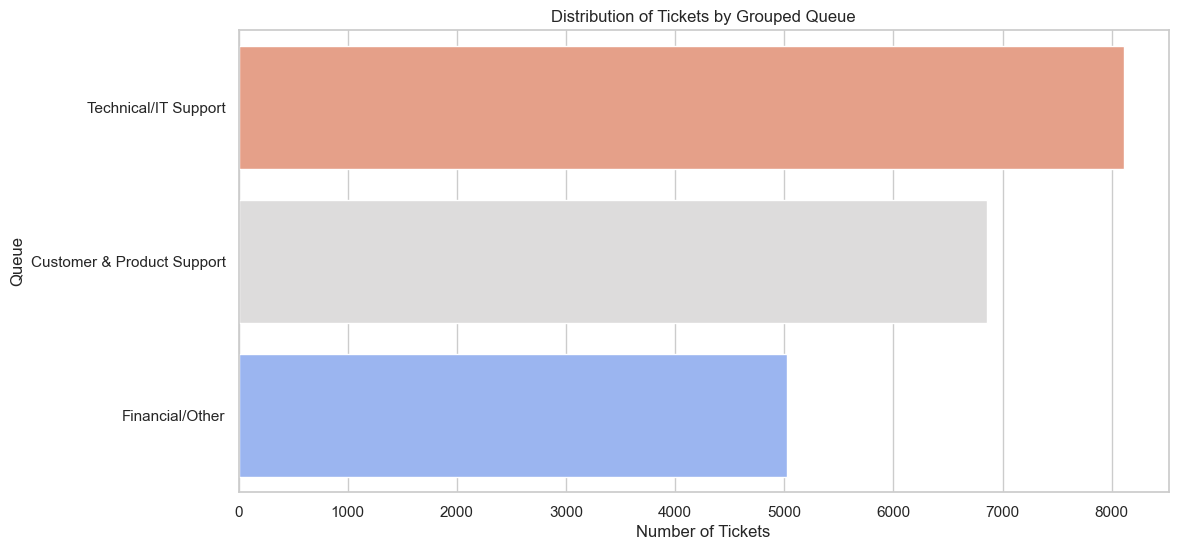

In [148]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.countplot(y=df_english_initial['grouped_queue'], order=df_english_initial['grouped_queue'].value_counts().index, palette="coolwarm", hue=df_english_initial['grouped_queue'])
plt.title("Distribution of Tickets by Grouped Queue")
plt.xlabel("Number of Tickets")
plt.ylabel("Queue")
plt.show()

In [149]:
check_class_imbalance(df_english_initial, 'grouped_queue')

,Counts,Percentage
grouped_queue,,
Technical/IT Support,8116,40.58
Customer & Product Support,6860,34.30
Financial/Other,5024,25.12


### Text Preprocessing

In NLP context, text preprocessing is a crucial step before feeding the data into any machine learning or deep learning model. Raw text data is complex, and models need the text to be clean and structured to better understand the information.

With the function `preprocess_text` we intend to achieve clean text by following several steps:

- Normalization: Converts all characters to lowercase.
- Expand Contractions: Expands contractions (e.g., "can't" to "cannot") for better understanding.
- Remove Noise: Eliminates irrelevant characters that do not add value.
- Tokenization: Splits the text into individual words or tokens.
- Remove Stopwords: Removes common words that don’t contribute much semantic value.
- Lemmatization: Reduces words to their base or root form for better analysis.
- Remove Short Tokens: Removes irrelevant words (such as "a", "I", "on") that may be considered noise.

In [150]:
df_english = df_english_initial[['grouped_queue','text_en']].copy()

In [151]:
df_english.head()

,grouped_queue,text_en
0,Financial/Other,Unexpected crash of the data analysis platform...
1,Customer & Product Support,Customer Support Inquiry Seeking information o...
2,Customer & Product Support,Data Analytics for Investment I am contacting ...
3,Customer & Product Support,Hospital service problem A media data blocking...
4,Customer & Product Support,"Security Dear Customer Support, I am reaching ..."


In [152]:
# Apply preprocessing function to the dataset
df_english['clean_text'] = df_english.apply(
    lambda row: preprocess_text(row['text_en']), axis=1
)

In [153]:
df_english[['text_en', 'clean_text']].head()

,text_en,clean_text
0,Unexpected crash of the data analysis platform...,unexpected crash data analysis platform data a...
1,Customer Support Inquiry Seeking information o...,customer support inquiry seeking information d...
2,Data Analytics for Investment I am contacting ...,data analytics investment contacting request i...
3,Hospital service problem A media data blocking...,hospital service problem medium data blocking ...
4,"Security Dear Customer Support, I am reaching ...",security dear customer support reaching inquir...


In [154]:
df_english.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   grouped_queue  20000 non-null  object
 1   text_en        20000 non-null  object
 2   clean_text     20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


##### Frequency Distribution

In [155]:
all_tokens = []

# Iterate through each cleaned text and tokenize it
for text in df_english['clean_text']:
    all_tokens.extend(nltk.word_tokenize(text))


In [156]:
# Create a frequency distribution
fdist = FreqDist(all_tokens)

print(fdist.most_common(10))

[('data', 19751), ('problem', 13718), ('support', 11779), ('issue', 11397), ('could', 11166), ('would', 10624), ('system', 7904), ('information', 7632), ('customer', 7089), ('software', 6988)]


In [157]:
# 30 most common words 
common_words = fdist.most_common(10)

common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

/var/folders/7t/tvwq6m6j5x379hykhkpqfxwh0000gn/T/ipykernel_42648/1652276497.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Frequency', data=common_words_df, palette="coolwarm")


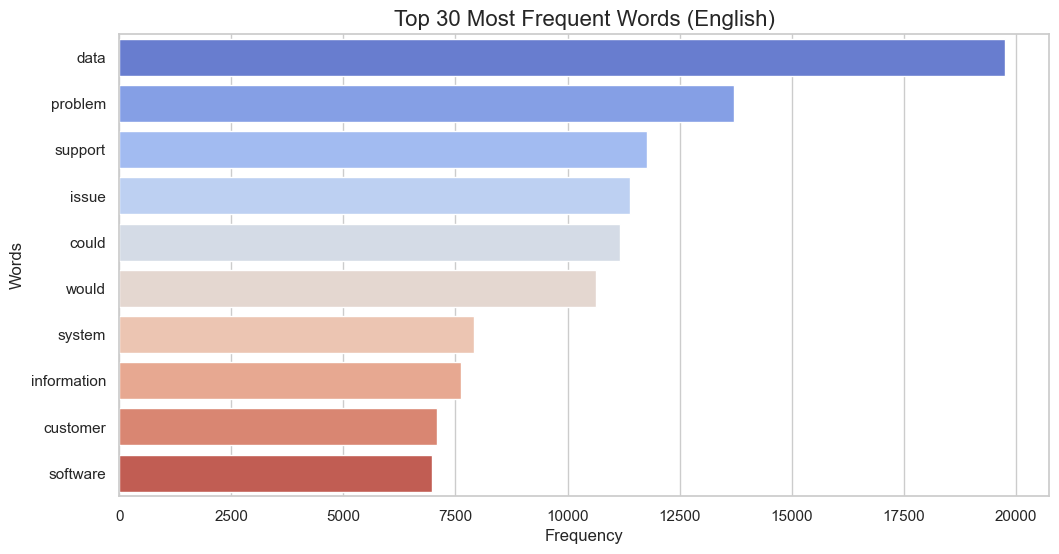

In [158]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(y='Word', x='Frequency', data=common_words_df, palette="coolwarm")
plt.title("Top 30 Most Frequent Words (English)", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Words", fontsize=12)

plt.show()

In [159]:
word_counts = Counter(all_tokens)
word_counts_df = pd.DataFrame(word_counts.items(), columns=["Word", "Frequency"])

num_unique_words = len(word_counts)
print(f"Number of different English words in the dataset: {num_unique_words}")

Number of different English words in the dataset: 6686


In [160]:
# Frequency thresholds
word_counts_aux = pd.DataFrame({"frequency": [10, 7, 5, 3, 2]})

# Calculate the number of words with a frequency lower than each threshold
word_counts_aux["number_of_english_words"] = word_counts_aux["frequency"].apply(
    lambda x: (word_counts_df["Frequency"] < x).sum()
)

# Display the result
print(word_counts_aux)


   frequency  number_of_english_words
0         10                     4041
1          7                     3692
2          5                     3315
3          3                     2601
4          2                     1913


This table suggests that the English dataset is highly sparse, with many words appearing only a few times:

- There are 4,041 unique English words that each appear exactly 10 times.
- There are 3,692 unique words that appear exactly 7 times.
- 3,315 words appear exactly 5 times.
- 2,601 words appear 3 times.
- 1,913 words appear 2 times.

Such low-frequency words are typically considered noise in text preprocessing. They are often domain-specific terms, misspellings, or irrelevant data that can introduce unnecessary complexity to the model and hinder the identification of meaningful patterns. 

However, in our case, we have chosen not to exclude any of these words. This decision ensures that we retain the full vocabulary, including rare or domain-relevant terms that might hold valuable information for the classification task. By preserving all tokens, we allow the model to potentially capture subtle but important patterns that could be lost through aggressive filtering.

##### Text Length Distribution

In [161]:
# Calculate text length (number of characters) for each text entry
df_english['text_length'] = df_english['clean_text'].apply(len)

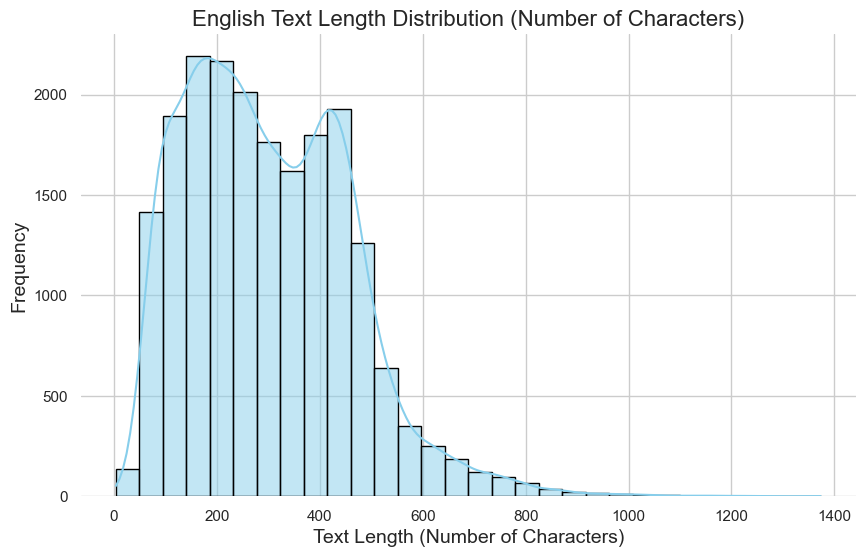

In [162]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_english['text_length'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('English Text Length Distribution (Number of Characters)', fontsize=16)
plt.xlabel('Text Length (Number of Characters)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
sns.despine(left=True, bottom=True)
plt.show()

In [163]:
# Calculate the number of words in each English text entry
df_english['word_count'] = df_english['clean_text'].apply(lambda x: len(x.split()))

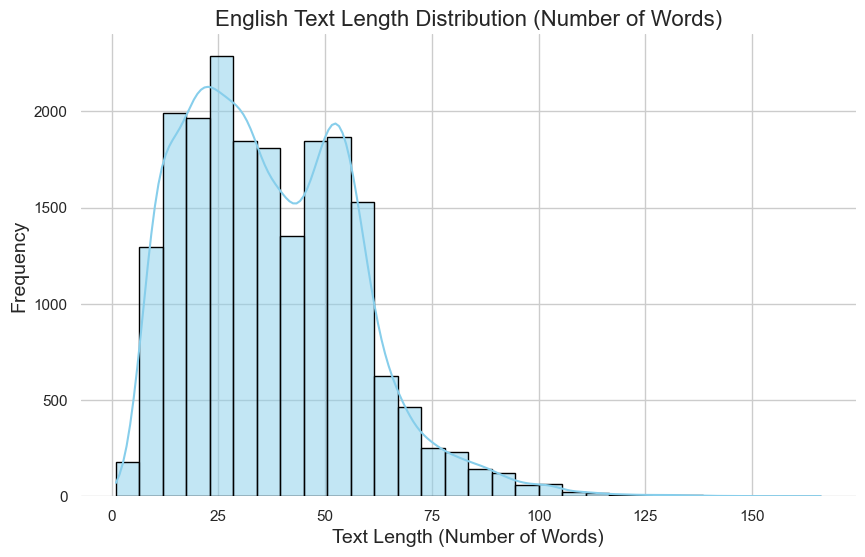

In [164]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_english['word_count'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('English Text Length Distribution (Number of Words)', fontsize=16)
plt.xlabel('Text Length (Number of Words)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
sns.despine(left=True, bottom=True)
plt.show()


In [165]:
df_english.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   grouped_queue  20000 non-null  object
 1   text_en        20000 non-null  object
 2   clean_text     20000 non-null  object
 3   text_length    20000 non-null  int64 
 4   word_count     20000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 781.4+ KB


In [166]:
df_english[['clean_text', 'text_length', 'word_count']].head()

,clean_text,text_length,word_count
0,unexpected crash data analysis platform data a...,177,24
1,customer support inquiry seeking information d...,179,24
2,data analytics investment contacting request i...,535,64
3,hospital service problem medium data blocking ...,170,21
4,security dear customer support reaching inquir...,467,59


In [167]:
# Sort by word_count in ascending order (shortest texts first)
df_shortest_english_texts = df_english[['clean_text', 'text_length', 'word_count']].sort_values(by='word_count', ascending=True)

df_shortest_english_texts.head()

,clean_text,text_length,word_count
549,help,4,1
12193,assist,6,1
4145,support needed,14,2
2084,problem synchronization,23,2
17796,concernregardingsysteminvestmentanalytics thec...,118,2


In [168]:
# Filter rows where the word_count is less than 3
short_texts = df_english[df_english['word_count'] < 3]
num_short_texts = short_texts.shape[0]
print(f"Number of records with less than 3 words: {num_short_texts}")

Number of records with less than 3 words: 6


As we can see, there are only a few cases where the word count is really small. These cases are unlikely to provide valuable insights for assigning the correct team, so we will exclude them from the analysis.

In [169]:
# Drop rows where the word_count is less than 3
df_filtered = df_english[df_english['word_count'] >= 3]
num_short_texts = df_english.shape[0] - df_filtered.shape[0]
df_english = df_filtered

print(f"Number of records with less than 3 words: {num_short_texts}")

df_english.head()

Number of records with less than 3 words: 6


,grouped_queue,text_en,clean_text,text_length,word_count
0,Financial/Other,Unexpected crash of the data analysis platform...,unexpected crash data analysis platform data a...,177,24
1,Customer & Product Support,Customer Support Inquiry Seeking information o...,customer support inquiry seeking information d...,179,24
2,Customer & Product Support,Data Analytics for Investment I am contacting ...,data analytics investment contacting request i...,535,64
3,Customer & Product Support,Hospital service problem A media data blocking...,hospital service problem medium data blocking ...,170,21
4,Customer & Product Support,"Security Dear Customer Support, I am reaching ...",security dear customer support reaching inquir...,467,59


#### Save CSV

Finally, we export the cleaned data from `df_english` into a new .csv file for future use.

In [170]:
df_english.to_csv(
    path_or_buf=os.path.join("../data", "dataset_english_filtered_tickets.csv"),
    sep=";", 
    quoting=csv.QUOTE_ALL, 
    index=False
)

print("Filtered DataFrame has been saved as 'dataset_english_filtered_tickets.csv'.")


Filtered DataFrame has been saved as 'dataset_english_filtered_tickets.csv'.


### Word Cloud

Analyzing the most common words in our dataset can provide a quick snapshot of the dominant themes. In this case, we'll use a word cloud—a widely adopted visualization in NLP—to display words with sizes proportional to their occurrence.

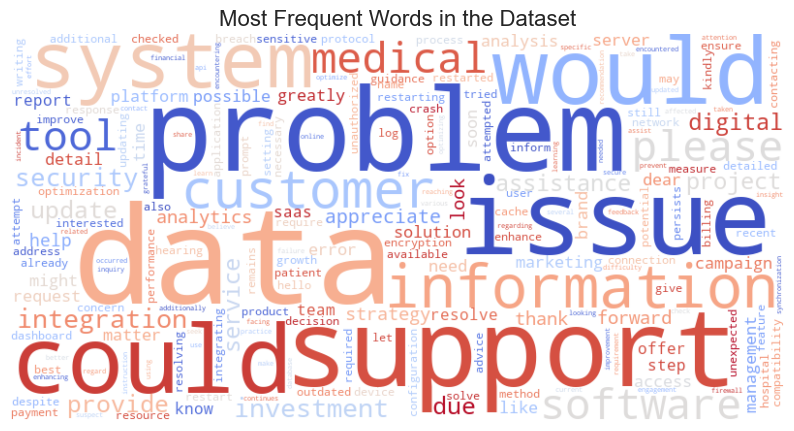

In [171]:
generate_wordcloud(df_english, stopwords=stop_words_en)

As expected, and aligning with the frequency distribution analysis, the two most frequent words are `problem` and `data`. 

#### Data Enhancement

To expand our dataset, we identified another source, `all_tickets`, which has already been preprocessed and can significantly enhance our data. This addition is particularly valuable because it provides a broader range of information. The dataset contains 13 distinct classes, although we removed two due to inconsistencies. These classes will be mapped to the existing categories in `df_english` as follows:

- **Class 1 - Technical/IT Support**:** includes categories 1 and 8
- **Class 2 - Customer & Product Support:** includes categories 2, 3, 7 and 12
- **Class 3 - Financial/Other:** includes category 5, 9 and 11

This mapping ensures that we integrate the relevant information effectively, improving the overall quality of our dataset.

In [211]:
# Read the CSV file into a DataFrame
df_enhanced_initial = pd.read_csv('../data/all_tickets.csv')
df_enhanced_initial.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [212]:
df_enhanced_filtered = df_enhanced_initial[['title', 'body', 'category', 'urgency']].copy()
df_enhanced_filtered.head()

,title,body,category,urgency
0,NaN,hi since recruiter lead permission approve req...,4,3
1,connection with icon,icon dear please setup icon per icon engineers...,6,3
2,work experience user,work experience user hi work experience studen...,5,3
3,requesting for meeting,requesting meeting hi please help follow equip...,5,3
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,4,3


**Check for duplicates**

In [213]:
duplicate_count = df_enhanced_filtered.duplicated().sum()
print(f"Number of duplicate records: {duplicate_count}")

Number of duplicate records: 0


**Check datatypes and missing values**


In [214]:
df_enhanced_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     47837 non-null  object
 1   body      48549 non-null  object
 2   category  48549 non-null  int64 
 3   urgency   48549 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


We can observe again some missing values in the title, so we will concatenate `title` and `body` as in our original df. 

In [215]:
nan_in_both = df_enhanced_filtered[ df_enhanced_filtered['body'].isna() & df_enhanced_filtered['title'].isna() ].shape[0]
print(f"Number of records with NaN in both 'body' and 'subject': {nan_in_both}")

Number of records with NaN in both 'body' and 'subject': 0


In [216]:
df_enhanced = df_enhanced_filtered.copy()
df_enhanced['text'] = df_enhanced['title'].fillna('') + " " + df_enhanced['body'].fillna('')
df_enhanced = df_enhanced.drop(columns=['title', 'body'])
df_enhanced.head()

,category,urgency,text
0,4,3,hi since recruiter lead permission approve re...
1,6,3,connection with icon icon dear please setup ic...
2,5,3,work experience user work experience user hi w...
3,5,3,requesting for meeting requesting meeting hi p...
4,4,3,reset passwords for external accounts re expir...


In [217]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  48549 non-null  int64 
 1   urgency   48549 non-null  int64 
 2   text      48549 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


As before, no missing values are present.

**Category Mapping**

In [218]:
category_mapping = {
    1: 'Technical/IT Support',
    2: 'Customer & Product Support',
    3: 'Customer & Product Support',
    5: 'Financial/Other',
    6: 'Customer & Product Support',
    7: 'Customer & Product Support',
    8: 'Technical/IT Support',
    9: 'Financial/Other',
    11: 'Financial/Other',
    12: 'Customer & Product Support'
}

In [219]:
# Apply the mapping to the 'category' column
df_enhanced['grouped_queue'] = df_enhanced['category'].map(category_mapping)

In [220]:
df_enhanced.head()

,category,urgency,text,grouped_queue
0,4,3,hi since recruiter lead permission approve re...,NaN
1,6,3,connection with icon icon dear please setup ic...,Customer & Product Support
2,5,3,work experience user work experience user hi w...,Financial/Other
3,5,3,requesting for meeting requesting meeting hi p...,Financial/Other
4,4,3,reset passwords for external accounts re expir...,NaN


**Join with original df**

In [221]:
df_english_join = df_english[['grouped_queue', 'text_en']].copy()
df_english_join.rename(columns={'text_en': 'text'}, inplace=True)

df_english_join.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19994 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   grouped_queue  19994 non-null  object
 1   text           19994 non-null  object
dtypes: object(2)
memory usage: 468.6+ KB


In [222]:
df_enhanced_join = df_enhanced[['grouped_queue', 'text']].copy()

df_enhanced_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   grouped_queue  14482 non-null  object
 1   text           48549 non-null  object
dtypes: object(2)
memory usage: 758.7+ KB


In [223]:
df_union = pd.concat([df_english_join, df_enhanced_join], ignore_index=True)

In [224]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68543 entries, 0 to 68542
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   grouped_queue  34476 non-null  object
 1   text           68543 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [225]:
df_union = df_union.dropna()
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34476 entries, 0 to 68540
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   grouped_queue  34476 non-null  object
 1   text           34476 non-null  object
dtypes: object(2)
memory usage: 808.0+ KB


In [226]:
check_class_imbalance(df_union, 'grouped_queue')

,Counts,Percentage
grouped_queue,,
Financial/Other,15458,44.84
Customer & Product Support,10594,30.73
Technical/IT Support,8424,24.43


### Train, Validation and Test Sets

To train the models, we divided the filtered English dataset into three subsets: training, validation, and test. This ensures proper evaluation and helps prevent overfitting by validating the model's performance on unseen data.

In [227]:
train, test_and_valid = train_test_split(df_union, train_size=0.8, random_state=35, stratify=df_union['grouped_queue'])

In [228]:
test, valid = train_test_split(test_and_valid, train_size=0.5, random_state=35, stratify=test_and_valid['grouped_queue'])

In [229]:
train.shape, valid.shape, test.shape

((27580, 2), (3448, 2), (3448, 2))

**Creating the CSV files**

In [230]:
train.to_csv(
    path_or_buf=os.path.join("../data", "ticket_train.csv"),
    sep=";", 
    quoting=csv.QUOTE_ALL, 
    index=False
)


In [231]:
test.to_csv(
    path_or_buf=os.path.join("../data", "ticket_test.csv"),
    sep=";", 
    quoting=csv.QUOTE_ALL, 
    index=False
)


In [232]:
valid.to_csv(
    path_or_buf=os.path.join("../data", "ticket_valid.csv"),
    sep=";", 
    quoting=csv.QUOTE_ALL, 
    index=False
)
